In [2]:
import pandas as pd

In [3]:
def get_data_dev(path= './dataset/realtime/raw_ethusdt_1m.csv', nrow= 100, result= 'dict'):
    
    csv_header = ['priceChange', 'priceChangePercent', 
                  'weightedAvgPrice', 'openPrice', 
                  'highPrice', 'lowPrice', 
                  'lastPrice', 'volume', 
                  'quoteVolume', 'openTime', 
                  'closeTime', 'firstId', 
                  'lastId', 'count'
                  ]

    if nrow == 0:
        nrow = 99999999999999999999
    df = pd.read_csv(path, names= csv_header, nrows= nrow)
    if result == 'df':
        return df
    # df_eth.head()
    lst_dct = df.to_dict('records')
    print('total record :', len(lst_dct))
    return lst_dct


In [4]:
path = r'E:\DADS\DADS6005_Realtime_Analytics\realtime-ml-kafka-crypto\dataset\realtime\raw_ethusdt_1m.csv'
df_raw = get_data_dev(path, nrow=5000, result= 'df')
lst_raw = get_data_dev(path, nrow=500, result= 'dict')
df_raw.head(1)

total record : 500


,priceChange,priceChangePercent,weightedAvgPrice,openPrice,highPrice,lowPrice,lastPrice,volume,quoteVolume,openTime,closeTime,firstId,lastId,count
0,0.53,0.024,2248.563963,2248.53,2249.06,2248.1,2249.06,241.2897,542555.324125,1.702720e+12,1.702720e+12,1.254227e+09,1.254228e+09,632.0


In [5]:
len(lst_raw)

500

In [6]:
lst_data = df_raw[['priceChangePercent', 'openPrice', 'highPrice', 'lowPrice', 'lastPrice', 'volume']].to_dict('records')
lst_data[0:2]

[{'priceChangePercent': 0.024,
  'openPrice': 2248.53,
  'highPrice': 2249.06,
  'lowPrice': 2248.1,
  'lastPrice': 2249.06,
  'volume': 241.2897},
 {'priceChangePercent': 0.024,
  'openPrice': 2248.53,
  'highPrice': 2249.06,
  'lowPrice': 2248.1,
  'lastPrice': 2249.06,
  'volume': 252.5022}]

# DRIFT DETECTION

In [15]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_data(data, dist_a, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(data, label='Stream')
    ax2.grid(axis='y')
    ax2.hist(dist_a, label=r'$dist_a$')
    # ax2.hist(dist_b, label=r'$dist_b$')
    # ax2.hist(dist_c, label=r'$dist_c$')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='r')
    plt.show()

Change detected at index 223 lastPrice :2248.76
Change detected at index 415 lastPrice :2247.08
Change detected at index 703 lastPrice :2246.46
Change detected at index 767 lastPrice :2248.16
Change detected at index 895 lastPrice :2246.31
Change detected at index 1055 lastPrice :2246.17
Change detected at index 1183 lastPrice :2247.12
Change detected at index 1311 lastPrice :2247.9
Change detected at index 1407 lastPrice :2245.13
Change detected at index 1535 lastPrice :2245.96
Change detected at index 1663 lastPrice :2245.37
Change detected at index 1791 lastPrice :2245.64
Change detected at index 1983 lastPrice :2244.7
Change detected at index 2143 lastPrice :2245.62
Change detected at index 2271 lastPrice :2246.56
Change detected at index 2399 lastPrice :2245.78
Change detected at index 2623 lastPrice :2246.09
Change detected at index 2815 lastPrice :2247.44
Change detected at index 2943 lastPrice :2245.93
Change detected at index 3135 lastPrice :2246.93
Change detected at index 33

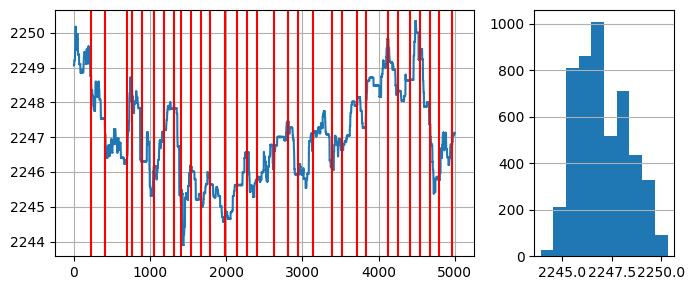

In [17]:
from river import drift


drift_detector = drift.ADWIN()
drifts = []

for i, val in enumerate(lst_data):
    drift_detector.update(val['lastPrice'])   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i} lastPrice :{val["lastPrice"]}')
        drifts.append(i)
        drift_detector._reset()  # As a best practice, we reset the detector

data = [x['lastPrice'] for x in lst_data]
plot_data(data, data,drifts)

In [55]:
plot_data()

TypeError: plot_data() missing 2 required positional arguments: 'data' and 'dist_a'

## FROM GPT

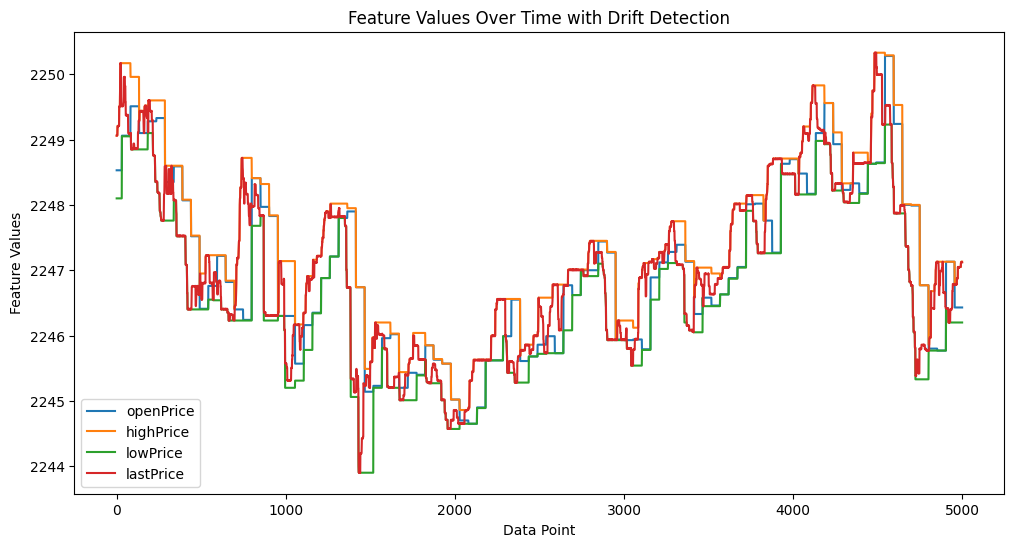

In [56]:
from river.drift import ADWIN
from river import stream
import matplotlib.pyplot as plt
from pandas import to_datetime
from datetime import timedelta

# Create an ADWIN detector for each feature you want to monitor for drift
drift_detectors = {
    'openPrice': ADWIN(),
    'highPrice': ADWIN(),
    'lowPrice': ADWIN(),
    'lastPrice': ADWIN(),
    # 'volume': ADWIN(),
    # 'priceChangePercent': ADWIN(),
}

dct_drifts = {
    'openPrice': [],
    'highPrice': [],
    'lowPrice': [],
    'lastPrice':[],
    # 'volume': [],
    # 'priceChangePercent': [],
}

# Simulate a data stream (replace this with your actual data stream)
data_stream =  lst_data #stream.iter_array .iter_objects(lst_data)
# data_stream = stream.iter_objects([
#     {'priceChangePercent': 0.024, 'openPrice': 2248.53, 'highPrice': 2249.06, 'lowPrice': 2248.1, 'lastPrice': 2249.06, 'volume': 241.2897},
#     {'priceChangePercent': 0.024, 'openPrice': 2248.53, 'highPrice': 2249.06, 'lowPrice': 2248.1, 'lastPrice': 2249.06, 'volume': 252.5022}
# ])

# Lists to store data for plotting
timestamps = []
feature_values = {feature: [] for feature in drift_detectors}

# Iterate through the data stream and update drift detectors
for i, data_point in enumerate(data_stream):
    timestamps.append(i)

    # Check for drift for each feature
    for feature_name, value in data_point.items():
        if feature_name in drift_detectors:
            drift_detected = drift_detectors[feature_name].update(value)
            
            # Append feature values for plotting
            feature_values[feature_name].append(value)

            if drift_detected:
                print(f'Drift detected for {feature_name} at data point {i}')
                dct_drifts[feature_name].append(i)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for feature_name, values in feature_values.items():
    ax.plot(timestamps, values, label=feature_name)

# Mark drift points on the plot
for feature_name, detector in drift_detectors.items():
    # for drift_point in detector.change_detected_at:
    for drift_point in dct_drifts[feature_name]:
        ax.axvline(drift_point, color='red', linestyle='--', label=f'{feature_name} Drift Point')
        
        
for feature_name, detector in drift_detectors.items():
    for i in range(len(dct_drifts[feature_name]) - 1):
        start = dct_drifts[feature_name][i]
        end = dct_drifts[feature_name][i + 1]
        ax.fill_betweenx(y=[min(ax.get_ylim()), max(ax.get_ylim())],
                         x1=start, x2=end, color='yellow', alpha=0.3)


ax.set_xlabel('Data Point')
ax.set_ylabel('Feature Values')
ax.set_title('Feature Values Over Time with Drift Detection')
ax.legend()
plt.show()


In [58]:
for k,v in dct_drifts.items():
    print(len(v))

0
0
0
0
